## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

In [7]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


What are the categorical variables? What are the numerical?

In [8]:
########## Categorical variables
df.select_dtypes(['object'])

,home,marital,records,job
0,rent,married,no,freelance
1,rent,widow,no,fixed
2,owner,married,yes,freelance
3,rent,single,no,fixed
4,rent,single,no,fixed
...,...,...,...,...
4449,rent,married,no,fixed
4450,owner,married,no,fixed
4451,owner,married,no,partime
4452,rent,single,no,freelance


In [9]:
########## numerical variables
df.select_dtypes(['int64','int32'])

,seniority,time,age,expenses,income,assets,debt,amount,price,default
0,9,60,30,73,129,0,0,800,846,0
1,17,60,58,48,131,0,0,1000,1658,0
2,10,36,46,90,200,3000,0,2000,2985,1
3,0,60,24,63,182,2500,0,900,1325,0
4,0,36,26,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...
4449,1,60,39,69,92,0,0,900,1020,1
4450,22,60,46,60,75,3000,600,950,1263,0
4451,0,24,37,60,90,3500,0,500,963,1
4452,0,48,23,49,140,0,0,550,550,0


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
df_train, df_test_valid = train_test_split(df, test_size=0.4,random_state=1)   ### 60% for training data
df_valid, df_test = train_test_split(df_test_valid, test_size=0.5, random_state=1) ### 20% for validation and the other 20% for test set

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [11]:
seniority_auc_score = roc_auc_score(df_train.default, df_train.seniority)
time_auc_score = roc_auc_score(df_train.default, df_train.time)
income_auc_score = roc_auc_score(df_train.default, df_train.income)
debt_auc_score = roc_auc_score(df_train.default, df_train.debt)

auc_dict = {
    'seniority': seniority_auc_score,
    'time': time_auc_score,
    'income': income_auc_score,
    'debt': debt_auc_score
}
## Replace AUC if it is less than half
for index in auc_dict:
    if auc_dict[index] < 0.5:
        auc_dict[index] = roc_auc_score(df_train.default, -df_train[index])

auc_df = pd.DataFrame.from_dict(auc_dict, orient='index')
auc_df = auc_df.rename(columns={
    0: 'auc_score'
})

## Here it's shown that the first column 'seniority' is having the highest auc value
auc_df = auc_df.sort_values(by = 'auc_score',ascending=False)
auc_df

,auc_score
seniority,0.698955
income,0.671084
time,0.554744
debt,0.502575


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [12]:
auc_df.head(1)

,auc_score
seniority,0.698955


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [13]:
## Getting just the requested columns
model_training_columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']
x_train = df_train[model_training_columns]
x_validation = df_valid[model_training_columns]
x_test = df_test[model_training_columns]

## output values
y_train = df_train.default
y_valid = df_valid.default
y_test = df_test.default

## Applying One-hot encoding
train_dict = x_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)

## create and train the model
model = LogisticRegression(solver='liblinear',C=1.0, max_iter=1000)
model.fit(x_train, y_train)



LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [14]:
## Pre-Process x validation datas

x_valid_dict = x_validation.to_dict(orient='records')
x_valid = dv.transform(x_valid_dict)

## Predict values
y_pred = model.predict_proba(x_valid)

## Get the second column of the y_pred
y_pred = y_pred[:,1]

## Calculate the auc score
model_auc_score = roc_auc_score(y_valid, y_pred)

print('AUC Score is: ',round(model_auc_score,3))

AUC Score is:  0.799


#### This shows it's near 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [15]:
## compute the precision and recall for every thresholds
def evaluate_model(y_true, y_pred):
    
    thresholds = np.arange(0, 1, 0.01)
    ## precision and recall for every threshold
    precision_recall_arr = []
    scores = []
    
    for threshold in thresholds:
        
        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)
        
        predicted_positive = (y_pred >= threshold)
        predicted_negative = (y_pred < threshold)
        
        ## make the y_predict Boolean values 
        y_predict = y_pred > threshold
        
        ## True Positive
        TP = (predicted_positive & actual_positive).sum()

        ## True Negative
        TN = (predicted_negative & actual_negative).sum()

        ## False Positive
        FP = (predicted_positive & actual_negative).sum()
        
        ## False Negative
        FN = (predicted_negative & actual_positive).sum()

        precision = TP / (TP + FP)
        recall = TP / ( TP + FN )
        scores.append((threshold, TP, TN, FP, FN, precision, recall))
        
    ## Create a dataframe of the results
    columns = ['Threshold', 'TP', 'TN', 'FP', 'FN', 'Precision', 'Recall']
    Data = pd.DataFrame(scores, columns=columns)
    
    return Data

results_df = evaluate_model(y_valid, y_pred)
results_df[::10]

<ipython-input-15-f18b10c03b15>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = TP / (TP + FP)
<ipython-input-15-f18b10c03b15>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = TP / (TP + FP)
<ipython-input-15-f18b10c03b15>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = TP / (TP + FP)


,Threshold,TP,TN,FP,FN,Precision,Recall
0,0.0,269,0,622,0,0.301908,1.000000
10,0.1,259,186,436,10,0.372662,0.962825
20,0.2,218,380,242,51,0.473913,0.810409
30,0.3,182,488,134,87,0.575949,0.676580
40,0.4,137,550,72,132,0.655502,0.509294
50,0.5,110,575,47,159,0.700637,0.408922
60,0.6,73,591,31,196,0.701923,0.271375
70,0.7,44,612,10,225,0.814815,0.163569
80,0.8,29,618,4,240,0.878788,0.107807
90,0.9,13,621,1,256,0.928571,0.048327


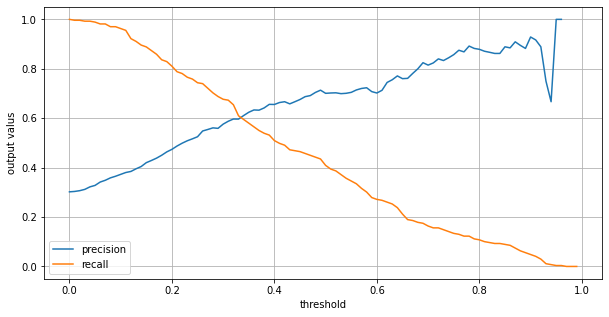

In [16]:
plt.figure(figsize=(10,5))
plt.plot(results_df.Threshold, results_df.Precision)
plt.plot(results_df.Threshold, results_df.Recall)

plt.legend(['precision', 'recall'])
plt.grid(True)
plt.xlabel('threshold')
plt.ylabel('output valus')

plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* **0.4**
* 0.6


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

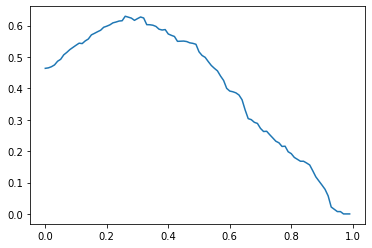

In [17]:
F1_scores = []
for index in range(100):
    indexed_recall = results_df.Recall[index]
    indexed_precision = results_df.Precision[index]
    F1 = (2 * indexed_precision * indexed_recall) / (indexed_precision + indexed_recall)
    if pd.isna(F1):
        F1 = 0
    F1_scores.append(F1)
plt.plot(results_df.Threshold, F1_scores)

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [19]:
thresholds = np.arange(0, 1, 0.01)

## Get the maximal F1 Score and it's index
max_F1 = np.array(F1_scores).max()
index = F1_scores.index(max_F1)
thresholds[index]

0.26

<b>This Shows at threshold 0.26, F1 score is maxiaml<b>

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [20]:
def train_model(df, y,C = 1.0):
    df_dict = df.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(df_dict)
    
    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X, y)
    
    return dv, model

def predict(df, dv, model):
    df_dict = df.to_dict(orient='records')
    
    x = dv.transform(df_dict)
    y_pred = model.predict_proba(x)[:,1]
    
    return y_pred


In [21]:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []
for train_idx, valid_idx in kfold.split(df_train):
    training_part = df_train.iloc[train_idx]
    validation_part = df_train.iloc[valid_idx]
    
    X_training_part = training_part[model_training_columns]
    X_validation_part = validation_part[model_training_columns]
    
    y_training_part = training_part.default
    y_validation_part = validation_part.default
    
    dv, model = train_model(X_training_part, y_training_part)
    y_prediction = predict(X_validation_part,dv, model)
    
    auc_score = roc_auc_score(y_validation_part, y_prediction)
    aucs.append(auc_score)
print('AUC Scores: ',aucs)
print('auc: %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

AUC Scores:  [0.8101383949008698, 0.7902880498248345, 0.8387909544159544, 0.8318968672229542, 0.8167214750221697]
auc: 0.818 ± 0.017


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

**It's actually 0.17**

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [22]:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for c_value in [0.01, 0.1, 1, 10]:
    aucs = []
    for train_idx, valid_idx in kfold.split(df_train):
        training_part = df_train.iloc[train_idx]
        validation_part = df_train.iloc[valid_idx]

        X_training_part = training_part[model_training_columns]
        X_validation_part = validation_part[model_training_columns]

        y_training_part = training_part.default
        y_validation_part = validation_part.default

        dv, model = train_model(X_training_part, y_training_part, C=c_value)
        y_prediction = predict(X_validation_part,dv, model)

        auc_score = roc_auc_score(y_validation_part, y_prediction)
        aucs.append(auc_score)
#     print('AUC Scores: ',aucs)
    print('auc= %0.3f ± %0.3f with C=' % (np.mean(aucs), np.std(aucs)),c_value)

auc= 0.807 ± 0.015 with C= 0.01
auc= 0.817 ± 0.017 with C= 0.1
auc= 0.818 ± 0.017 with C= 1
auc= 0.818 ± 0.017 with C= 10


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

**As We can see C with value of 10 has the biggest AUC value (0.818)**

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.